# **Análisis de la amenaza a sequía en escenarios históricos y actuales de transformación de las coberturas naturales en cuencas aledañas al PNN Chinganza**

# Desarrollo de los ánalisis

**Importar librerias**

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import shapely
import geopandas as gpd
import topojson as tp
import rasterio
import rasterio.plot
import rasterio.warp
import rasterio.mask
import pyproj
import seaborn as sns

**Cargar Dataset**

In [2]:
psig_root=r"C:/Users/Leydi/Documents/PSIG/data/ProyectoFinalSIG/"
AE = gpd.read_file(psig_root+'Area_Estudio/Area_Estudio_ProgSIG.shp')
AE_UAH_SC1 = gpd.read_file(psig_root+'Estres_Hidrico/AE_HUA_SC1.shp')
AE_UAH_SC2 = gpd.read_file(psig_root+'Estres_Hidrico/AE_HUA_SC2.shp')
AE_UAH_SC3 = gpd.read_file(psig_root+'Estres_Hidrico/AE_HUA_SC3.shp')
AE_UAH_SC4 = gpd.read_file(psig_root+'Estres_Hidrico/AE_HUA_SC4.shp')
Eco_ae = gpd.read_file(psig_root+'Eco_AE.shp')
PNN_chingaza = gpd.read_file(psig_root+'PNN/PNN_Chingaza.shp') 
AE_dissolve = gpd.read_file(psig_root+'Dissolve_ori.shp')

El área de estudio corresponde a cinco subzonas hidrografías aledaña y de influencia directa al PNN Chingaza: Río Guatiquía, Río Humea, Río Guacavía, Rio Guavio y Río Guayuriba, todas pertenecen al departamento del Meta


In [3]:
AE.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID_1  5 non-null      int32   
 1   COD_AH      5 non-null      int32   
 2   COD_ZH      5 non-null      int32   
 3   COD_SZH     5 non-null      int32   
 4   NOM_AH      5 non-null      object  
 5   NOM_ZH      5 non-null      object  
 6   NOM_SZH     5 non-null      object  
 7   Shape_Leng  5 non-null      float64 
 8   Shape_Area  5 non-null      float64 
 9   RULEID      5 non-null      int32   
 10  Area_Ha     5 non-null      float64 
 11  geometry    5 non-null      geometry
dtypes: float64(3), geometry(1), int32(5), object(3)
memory usage: 512.0+ bytes


In [4]:
AE.loc[:, ['NOM_ZH', 'NOM_SZH']]

,NOM_ZH,NOM_SZH
0,Meta,Río Guatiquía
1,Meta,Río Humea
2,Meta,Río Guacavía
3,Meta,Río Guavio
4,Meta,Río Guayuriba


<Axes: >

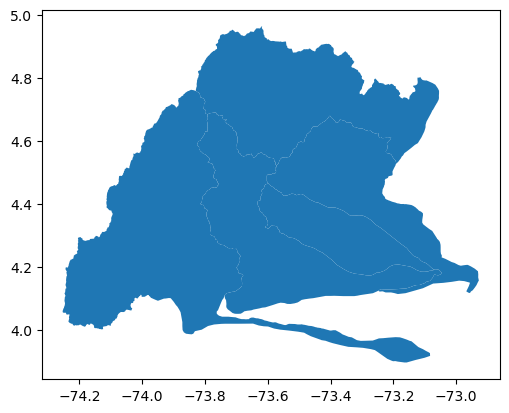

In [5]:
AE.plot()

Se reproyrectan las capas tanto para mejorar su visualización como para los análisis siguientes

In [6]:
AE.crs.is_geographic

True

In [7]:
AE_proj= AE.to_crs(9377)
print("AE reproyectado:", AE_proj.crs)

AE reproyectado: EPSG:9377


In [8]:
PNN_chingaza.crs.is_geographic

True

In [9]:
PNN_chingaza_proj= PNN_chingaza.to_crs(9377)
print("PNN_chingaza_proj reproyectado:", PNN_chingaza_proj.crs)

PNN_chingaza_proj reproyectado: EPSG:9377


Se visualiza el contexto del Parque Nacional Natural Chingaza con respecto al área del estudio

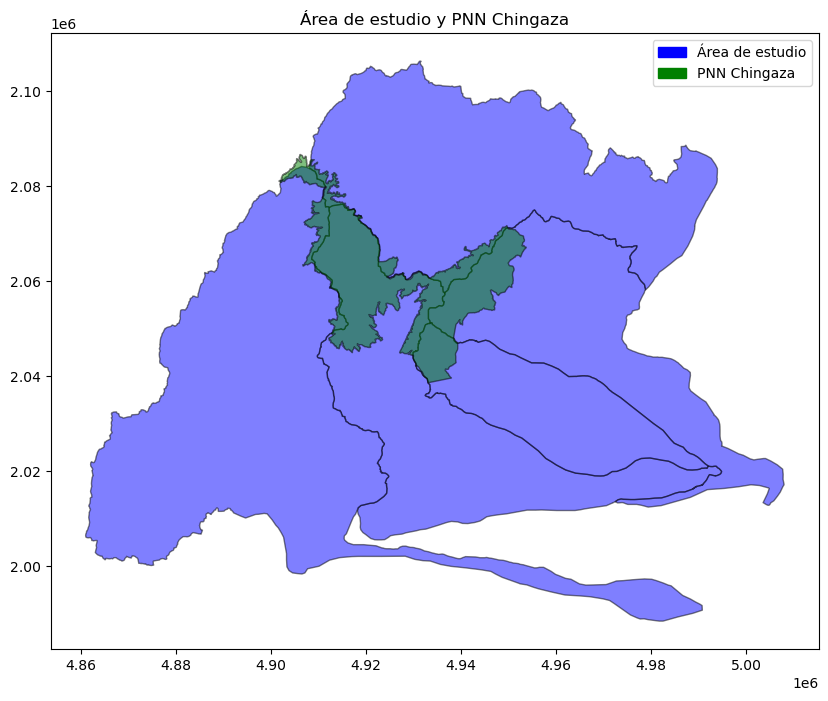

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))
AE_proj.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5, label="Área de estudio")
PNN_chingaza_proj.plot(ax=ax, color="green", edgecolor="black", alpha=0.5, label="PNN Chingaza")
leyenda_AE = mpatches.Patch(color="blue", label="Área de estudio")
leyenda_PNN_chingaza = mpatches.Patch(color="green", label="PNN Chingaza")
plt.legend(handles=[leyenda_AE, leyenda_PNN_chingaza])
plt.title("Área de estudio y PNN Chingaza")
plt.savefig("Area_estudio_PNN_Chingaza.jpg", dpi=300)
plt.show()

In [11]:
Eco_ae_proj = Eco_ae.to_crs(9377)
print("Eco_ae reproyectado:", Eco_ae_proj.crs)

Eco_ae reproyectado: EPSG:9377


In [12]:
Eco_ae_proj["area_ha"] = Eco_ae_proj.geometry.area / 10_000 
Eco_ae_proj["area_ha"] = Eco_ae_proj["area_ha"].round(2)

Se registran seis paisajes geomorfológicos en el área de estudio, siendo el paisaje mas representativo el de mosntaña

In [13]:
Eco_agg = Eco_ae_proj.groupby('PAISAJE')[['area_ha']].sum().reset_index()
Eco_agg

,PAISAJE,area_ha
0,Lomerio,32271.92
1,Montaña,668547.95
2,N.A.,37155.67
3,Piedemonte,119589.69
4,Planicie aluvial,68813.35
5,S.I.,1067.29
6,Valle,27022.65


In [14]:
Eco_ae_proj["PAISAJE"] = Eco_ae_proj["PAISAJE"].replace("N.A.", np.nan) 
Eco_ae_proj["PAISAJE"] = Eco_ae_proj["PAISAJE"].fillna("Rio")

<Axes: >

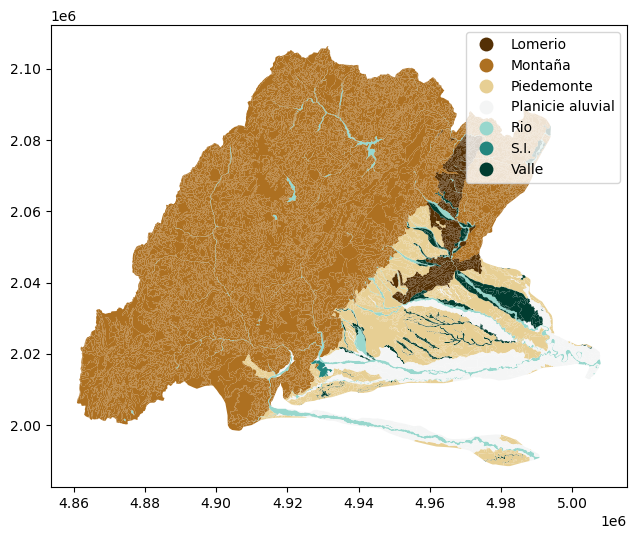

In [15]:
Eco_ae_proj.plot(column="PAISAJE", cmap="BrBG", legend=True, figsize=(10,6))

**Información hidrológica de la dinámica de caudales del modelo de Análisis Hidrológico realizado por Nogales et al, 2012 en su estudio “Hydrological Modeling for Multifunctional Landscape Planning in the Orinoquia Region of Colombia”.**

La unidad de análisis del modelo son UAH (Unidad de Análisis hidrológico) que comprende el área del acople de la cuenca superficial y el acuífero subterránea o misma unidad hidrogeológica. 
Con el modelo estima:

-El proceso de lluvia-escorrentía mediante el cálculo de la precipitación + evapotranspiración + recarga = escorrentía directa = cambio en el almacenamiento de uso
-La interacción rio-llanura de inundación 
-Procesos antrópicos de extracción de agua subterránea y superficial (agricultura, ganadería, doméstico, hidrocarburos, minería)
Luego generan cuatro escenarios de transformación del uso del agua para la región de la Orinoquia colombiana: 

**Escenario 1**
Puede considerarse como “seguir como siempre”, lo que representa una expansión modesta que se genera de manera óptima en términos de maximizar los beneficios agrícolas. Define una expansión del 1,51% de la palma aceitera, del 0,12% del arroz, del 0,08% de la silvicultura y del 0,04% de la soja.

_Para todas las capas de escenarios se reproyectar para luego calcular el área en hectáreas para cada intervalo de la variación de los caudales. La columna que contiene intervalo de la variación de caudal se convierte en una lista de números y luego se separa el valor máximo y mínimo para poder visualizar sus valores_ 

In [16]:
AE_UAH_SC1_proj= AE_UAH_SC1.to_crs(9377)
print("AE_UAH_SC1_proj:", AE_UAH_SC1_proj.crs)

AE_UAH_SC1_proj: EPSG:9377


In [17]:
AE_UAH_SC1_proj['numeros_lista_SC1'] = AE_UAH_SC1_proj['SC1_BAU_Rn'].str.findall(r'-?\d+')
AE_UAH_SC1_proj['numeros_lista_SC1'] = AE_UAH_SC1_proj['numeros_lista_SC1'].apply(lambda x: [int(num) for num in x])
n_expan_SC1 = pd.DataFrame(AE_UAH_SC1_proj['numeros_lista_SC1'].to_list(), index=AE_UAH_SC1_proj.index)
AE_UAH_SC1_proj = AE_UAH_SC1_proj.join(n_expan_SC1)
AE_UAH_SC1_proj = AE_UAH_SC1_proj.rename(columns={0: 'Max', 1: 'Min'})

In [18]:
AE_UAH_SC1_proj["area_ha"] = AE_UAH_SC1_proj.geometry.area / 10_000 
AE_UAH_SC1_proj["area_ha"] = AE_UAH_SC1_proj["area_ha"].round(2)

In [19]:
# Modificar NaN que representan valores >100, o 0 tanto en su rango maximi como minimo 
AE_UAH_SC1_proj.at[18, 'Min'] = 100
AE_UAH_SC1_proj.at[19, 'Min'] = 0

**Escenario 2**
Representa la visión de los pequeños agricultores, ganaderos y la industria agrícola en la región de la Orinoquia colombiana. Este escenario estableció que el 14,27% del paisaje se convertiría en agricultura dividiendo el área equitativamente entre los cinco productos básicos (palma aceitera, arroz, silvicultura, soja y pastos para el ganado).

In [20]:
AE_UAH_SC2_proj= AE_UAH_SC2.to_crs(9377)
print("AE_UAH_SC2_proj:", AE_UAH_SC2_proj.crs)

AE_UAH_SC2_proj: EPSG:9377


In [21]:
AE_UAH_SC2_proj['numeros_lista_SC2'] = AE_UAH_SC2_proj['SC2_Stkhol'].str.findall(r'-?\d+')
AE_UAH_SC2_proj['numeros_lista_SC2'] = AE_UAH_SC2_proj['numeros_lista_SC2'].apply(lambda x: [int(num) for num in x])
n_expan_SC2 = pd.DataFrame(AE_UAH_SC2_proj['numeros_lista_SC2'].to_list(), index=AE_UAH_SC2_proj.index)
AE_UAH_SC2_proj = AE_UAH_SC2_proj.join(n_expan_SC2)
AE_UAH_SC2_proj = AE_UAH_SC2_proj.rename(columns={0: 'Max', 1: 'Min'})

In [22]:
AE_UAH_SC2_proj["area_ha"] = AE_UAH_SC2_proj.geometry.area / 10_000 
AE_UAH_SC2_proj["area_ha"] = AE_UAH_SC2_proj["area_ha"].round(2)

In [23]:
# Modificar NaN que representan valores >100, o 0 tanto en su rango maximi como minimo 
AE_UAH_SC2_proj.at[16, 'Min'] = 100
AE_UAH_SC2_proj.at[17, 'Min'] = 0

**Escenario 3** 
Representa la visión del gobierno colombiano descrita en el Plan Maestro ( DNP, 2016 ), que busca maximizar la tierra subutilizada para la agricultura. Este escenario propone una expansión del 10,61% de la agricultura (que se dividiría equitativamente entre arroz y soja), el 13,53% de la ganadería, el 6,97% de la silvicultura y el 12,54% de los cultivos agroforestales (asignados a la palma aceitera).

In [24]:
AE_UAH_SC3_proj= AE_UAH_SC3.to_crs(9377)
print("AE_UAH_SC3_proj:", AE_UAH_SC3_proj.crs)

AE_UAH_SC3_proj: EPSG:9377


In [25]:
AE_UAH_SC3_proj['numeros_lista_SC3'] = AE_UAH_SC3_proj['SC3_Master'].str.findall(r'-?\d+')
AE_UAH_SC3_proj['numeros_lista_SC3'] = AE_UAH_SC3_proj['numeros_lista_SC3'].apply(lambda x: [int(num) for num in x])
n_expan_SC3 = pd.DataFrame(AE_UAH_SC3_proj['numeros_lista_SC3'].to_list(), index=AE_UAH_SC3_proj.index)
AE_UAH_SC3_proj = AE_UAH_SC3_proj.join(n_expan_SC3)
AE_UAH_SC3_proj = AE_UAH_SC3_proj.rename(columns={0: 'Max', 1: 'Min'})

In [26]:
AE_UAH_SC3_proj["area_ha"] = AE_UAH_SC3_proj.geometry.area / 10_000 
AE_UAH_SC3_proj["area_ha"] = AE_UAH_SC3_proj["area_ha"].round(2)

In [27]:
# Modificar NaN que representan valores >100, o 0 tanto en su rango maximi como minimo 
AE_UAH_SC3_proj.at[15, 'Min'] = 100

**Escenario 4**
Representa una visión extrema en la que toda la frontera agrícola está ocupada incluso si es un área protegida. Este escenario propone un 53,68% de expansión de toda la actividad productiva (palma aceitera, arroz, forestación, soja y pasturas para ganadería).

In [28]:
AE_UAH_SC4_proj= AE_UAH_SC4.to_crs(9377)
print("AE_UAH_SC4_proj:", AE_UAH_SC4_proj.crs)

AE_UAH_SC4_proj: EPSG:9377


In [29]:
AE_UAH_SC4_proj['numeros_lista_SC4'] = AE_UAH_SC4_proj['SC4_AgriFt'].str.findall(r'-?\d+')
AE_UAH_SC4_proj['numeros_lista_SC4'] = AE_UAH_SC4_proj['numeros_lista_SC4'].apply(lambda x: [int(num) for num in x])
n_expan_SC4 = pd.DataFrame(AE_UAH_SC4_proj['numeros_lista_SC4'].to_list(), index=AE_UAH_SC4_proj.index)
AE_UAH_SC4_proj = AE_UAH_SC4_proj.join(n_expan_SC4)
AE_UAH_SC4_proj = AE_UAH_SC4_proj.rename(columns={0: 'Max', 1: 'Min'})

In [30]:
AE_UAH_SC4_proj["area_ha"] = AE_UAH_SC4_proj.geometry.area / 10_000 
AE_UAH_SC4_proj["area_ha"] = AE_UAH_SC4_proj["area_ha"].round(2)

In [31]:
# Modificar NaN que representan valores >100, o 0 tanto en su rango maximi como minimo 
AE_UAH_SC4_proj.at[15, 'Min'] = 100
AE_UAH_SC4_proj.at[16, 'Min'] = 0

**Se grafica los escenarios en el cambio de los caudales en su nivel Max: el gradiente va desde la disminución de 100 % o el aumento del 100 % o mas (<100) del caudal en cada UAH**

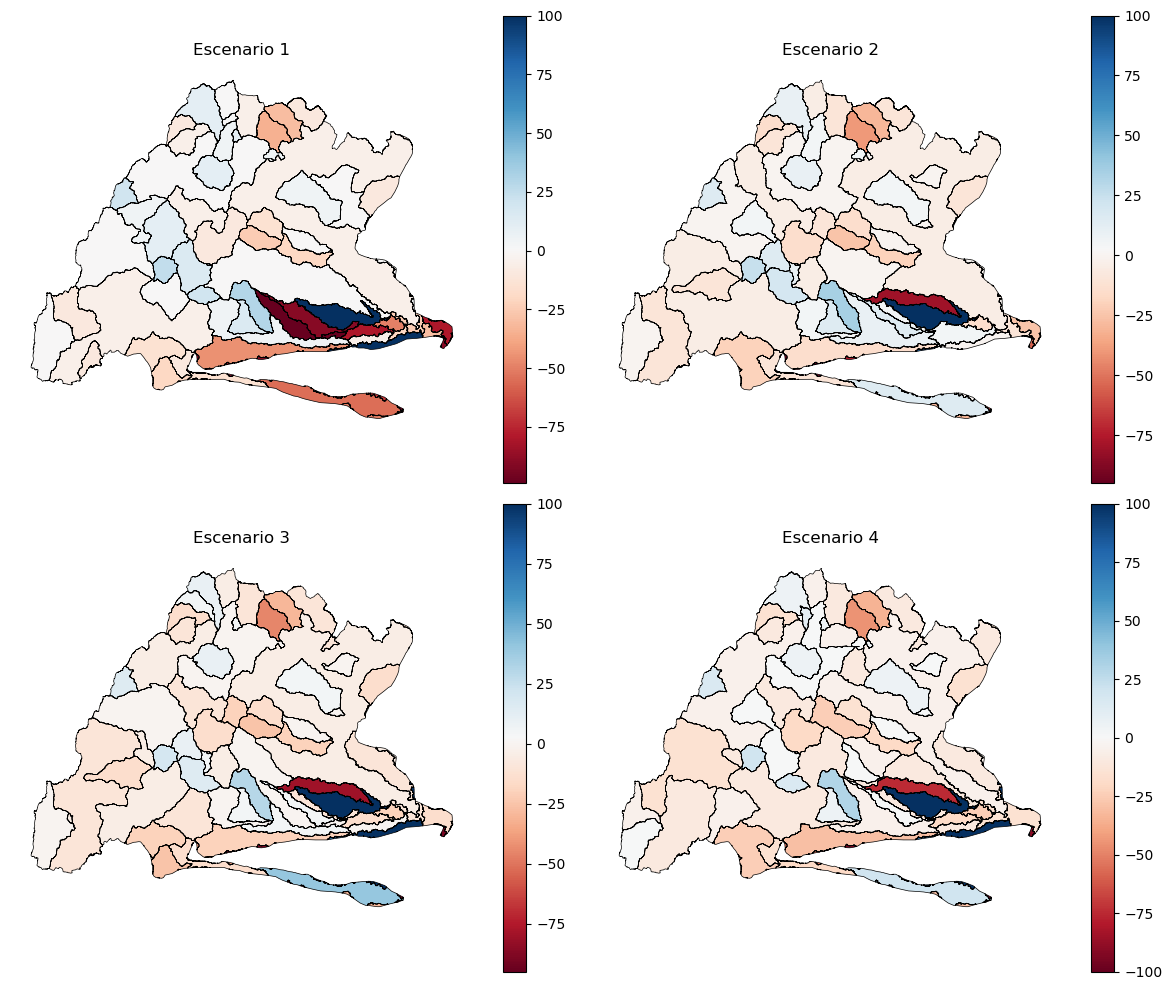

In [60]:
# Crear la figura y los subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 filas, 2 columnas
capas = [AE_UAH_SC1_proj, AE_UAH_SC2_proj, AE_UAH_SC3_proj, AE_UAH_SC4_proj]
titulos = ["Escenario 1", "Escenario 2", "Escenario 3", "Escenario 4"]

# Iterar sobre los ejes y graficar cada capa con la variable "Max"
for i, (gdf, ax) in enumerate(zip(capas, axes.flat)):
    gdf.plot(column="Max",  # Maximo valor del intervalo de caudal
             cmap="RdBu",  
             edgecolor="black",
             linewidth=0.5,
             legend=True,
             ax=ax)
    ax.set_title(titulos[i])  
    ax.axis("off")  

#Ajustar espacio entre gráficos
plt.tight_layout()
plt.savefig("Escenarios_caudales.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

C:\Users\Leydi\AppData\Local\Temp\ipykernel_6504\1495279458.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GeoDataFrame', y='Max', data=df_combined, palette='husl')


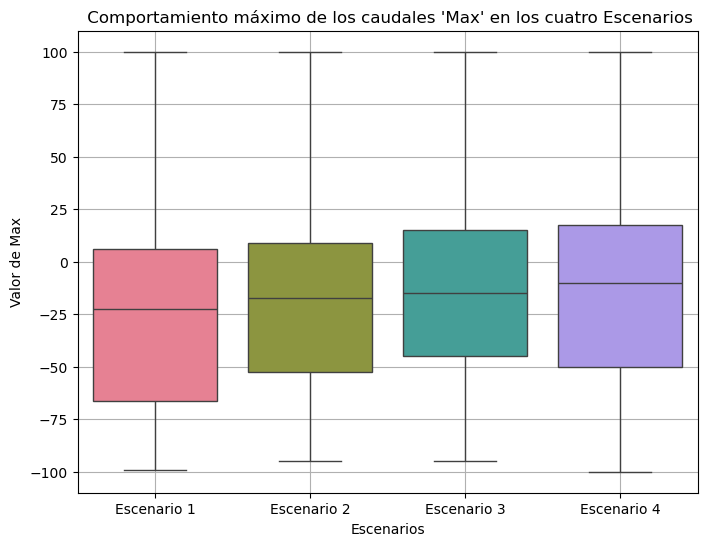

In [61]:
# Crear un DataFrame combinado con etiquetas para identificar cada GeoDataFrame
df_combined = pd.concat([
    AE_UAH_SC1_proj.assign(GeoDataFrame='Escenario 1'),
    AE_UAH_SC2_proj.assign(GeoDataFrame='Escenario 2'),
    AE_UAH_SC3_proj.assign(GeoDataFrame='Escenario 3'),
    AE_UAH_SC4_proj.assign(GeoDataFrame='Escenario 4')
])

# Crear el diagrama de caja y bigotes
plt.figure(figsize=(8, 6))
sns.boxplot(x='GeoDataFrame', y='Max', data=df_combined, palette='husl')

# Personalizar el gráfico
plt.title(" Comportamiento máximo de los caudales 'Max' en los cuatro Escenarios")
plt.xlabel("Escenarios")
plt.ylabel("Valor de Max")
plt.grid(True)

# Mostrar el gráfico
plt.savefig("Descripcion_caudales.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

Características de la distribución espacial de Estrés hídrico por sequías hidrológicas: Se presentará la distribución espacial de la dinámica de caudales analizadas en las Unidades de Análisis Hidrológico, y los niveles de intensidad en el déficit mediante la siguiente clasificación:

Niveles de intensidad
Déficit de -15 % y -30:	Débil
Déficit de -30 % y -45%:        Moderado
Déficit de más -45 %:  	Severo

In [34]:
# Definir los rangos y etiquetas para el escenario 1
bins = [-float('inf'), -45, -30, -15]  # Límites de las categorías
labels = ["Severo", "Moderado", "Débil"]  # Nombres de las categorías

# Asignar la categoría a cada valor de 'Max'
AE_UAH_SC1_proj['Nivel_Intensidad'] = pd.cut(AE_UAH_SC1_proj['Max'], bins=bins, labels=labels, right=False)

# Reemplazar NaN con "No Aplica"
AE_UAH_SC1_proj['Nivel_Intensidad'] = AE_UAH_SC1_proj['Nivel_Intensidad'].cat.add_categories("No Aplica").fillna("No Aplica")

In [35]:
# Definir los rangos y etiquetas para el escenario 2
bins = [-float('inf'), -45, -30, -15]  # Límites de las categorías
labels = ["Severo", "Moderado", "Débil"]  # Nombres de las categorías

# Asignar la categoría a cada valor de 'Max'
AE_UAH_SC2_proj['Nivel_Intensidad'] = pd.cut(AE_UAH_SC2_proj['Max'], bins=bins, labels=labels, right=False)

# Reemplazar NaN con "No Aplica"
AE_UAH_SC2_proj['Nivel_Intensidad'] = AE_UAH_SC2_proj['Nivel_Intensidad'].cat.add_categories("No Aplica").fillna("No Aplica")

In [36]:
# Definir los rangos y etiquetas para el escenario 3
bins = [-float('inf'), -45, -30, -15]  # Límites de las categorías
labels = ["Severo", "Moderado", "Débil"]  # Nombres de las categorías

# Asignar la categoría a cada valor de 'Max'
AE_UAH_SC3_proj['Nivel_Intensidad'] = pd.cut(AE_UAH_SC3_proj['Max'], bins=bins, labels=labels, right=False)

# Reemplazar NaN con "No Aplica"
AE_UAH_SC3_proj['Nivel_Intensidad'] = AE_UAH_SC3_proj['Nivel_Intensidad'].cat.add_categories("No Aplica").fillna("No Aplica")

In [37]:
# Definir los rangos y etiquetas para el escenario 3
bins = [-float('inf'), -45, -30, -15]  # Límites de las categorías
labels = ["Severo", "Moderado", "Débil"]  # Nombres de las categorías

# Asignar la categoría a cada valor de 'Max'
AE_UAH_SC4_proj['Nivel_Intensidad'] = pd.cut(AE_UAH_SC4_proj['Max'], bins=bins, labels=labels, right=False)

# Reemplazar NaN con "No Aplica"
AE_UAH_SC4_proj['Nivel_Intensidad'] = AE_UAH_SC4_proj['Nivel_Intensidad'].cat.add_categories("No Aplica").fillna("No Aplica")

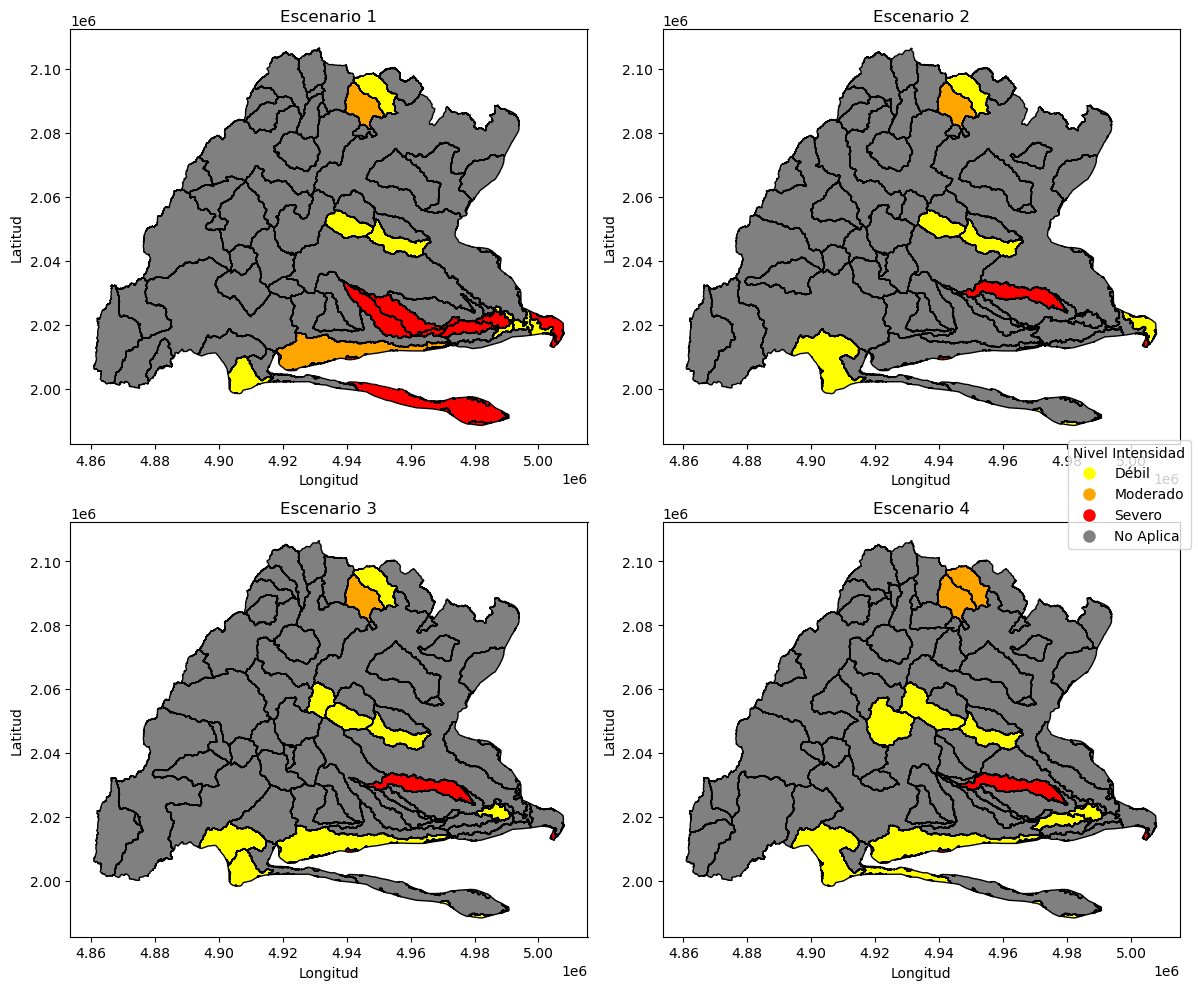

In [62]:
# Lista de GeoDataFrames
gdfs = [AE_UAH_SC1_proj, AE_UAH_SC2_proj, AE_UAH_SC3_proj, AE_UAH_SC4_proj]
titles = ["Escenario 1", "Escenario 2", "Escenario 3", "Escenario 4"]

# Definir colores
colormap = {"Débil": "yellow", "Moderado": "orange", "Severo": "red", "No Aplica": "gray"}

# Crear la figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Aplanar la matriz de ejes

# Iterar sobre cada GeoDataFrame y su respectivo subplot
for i, (gdf, ax, title) in enumerate(zip(gdfs, axes, titles)):

    gdf['Color'] = gdf['Nivel_Intensidad'].map(colormap)
    
    # Graficar cada GeoDataFrame en su subplot correspondiente
    gdf.plot(ax=ax, color=gdf['Color'], edgecolor="black", legend=True)
    
    # Título y etiquetas
    ax.set_title(title)
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

# Crear una leyenda común para todas las categorías
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cat, markersize=10, markerfacecolor=color) 
                   for cat, color in colormap.items()]
fig.legend(handles=legend_elements, title="Nivel Intensidad", loc="center right")

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.savefig("Niveles_Intensidad.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

**Se grafica los escenarios en el cambio de los caudales en su nivel Max: el gradiente va desde la disminución de 100 % o el aumento del 100 % o mas (<100) del caudal en cada UAH que hacen parte del PNN chingaza**

In [39]:
PNN_UAH_SC1_proj = gpd.clip(AE_UAH_SC1_proj, PNN_chingaza_proj)
PNN_UAH_SC2_proj = gpd.clip(AE_UAH_SC2_proj, PNN_chingaza_proj)
PNN_UAH_SC3_proj = gpd.clip(AE_UAH_SC3_proj, PNN_chingaza_proj)
PNN_UAH_SC4_proj = gpd.clip(AE_UAH_SC4_proj, PNN_chingaza_proj)

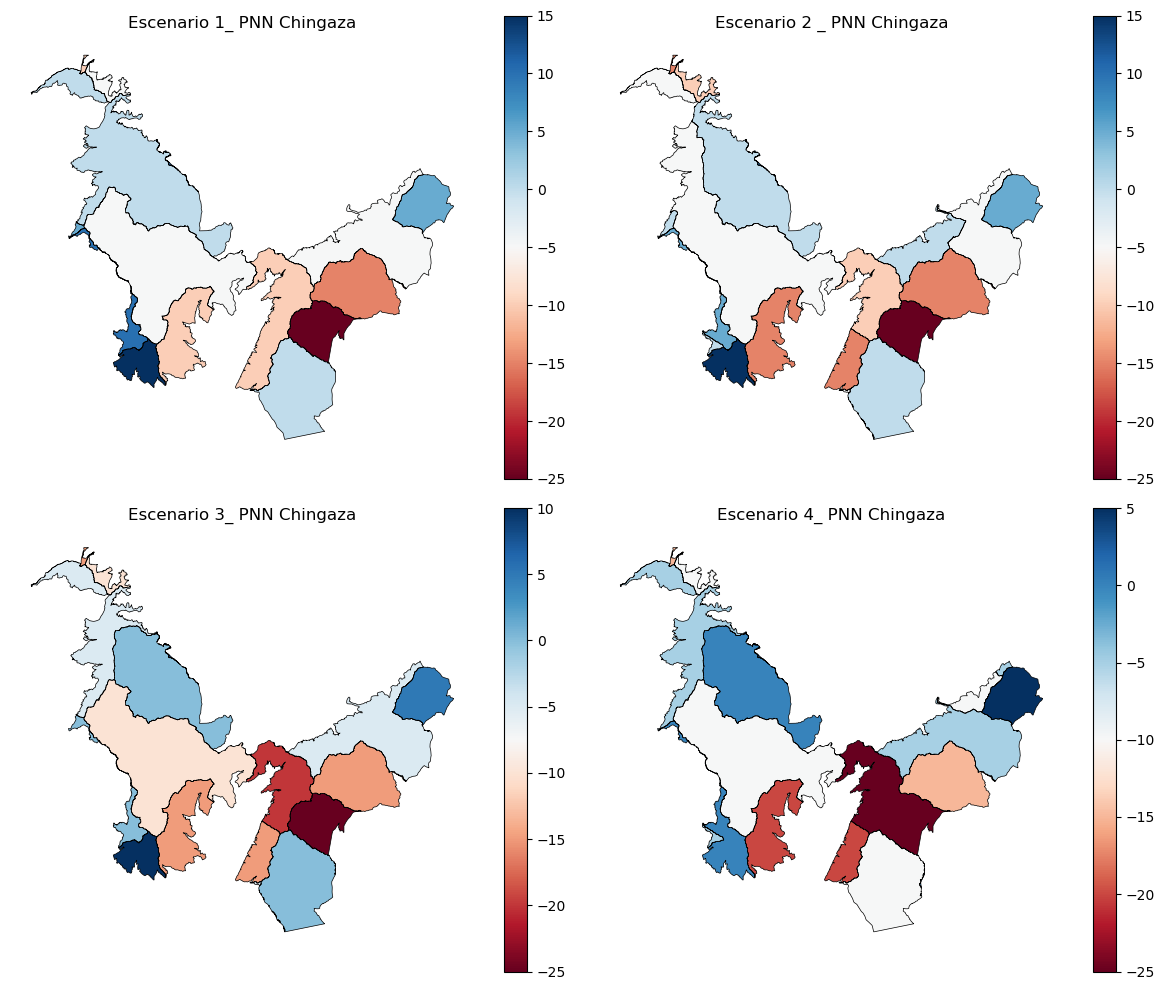

In [67]:
# Crear la figura y los subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 filas, 2 columnas
capas_pnn = [PNN_UAH_SC1_proj, PNN_UAH_SC2_proj, PNN_UAH_SC3_proj, PNN_UAH_SC4_proj]
titulos_pnn = ["Escenario 1_ PNN Chingaza", "Escenario 2 _ PNN Chingaza", "Escenario 3_ PNN Chingaza", "Escenario 4_ PNN Chingaza"]

# Iterar sobre los ejes y graficar cada capa con la variable "Max"
for i, (gdf, ax) in enumerate(zip(capas_pnn, axes.flat)):
    gdf.plot(column="Max",  # Maximo valor del intervalo de caudal
             cmap="RdBu",  
             edgecolor="black",
             linewidth=0.5,
             legend=True,
             ax=ax)
    ax.set_title(titulos_pnn[i])  
    ax.axis("off")  

#Ajustar espacio entre gráficos
plt.tight_layout()
plt.savefig("Dinamica_PNNChingaza.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

En el área de estudio que comprende las cinco cuencas hidrográficas aledañas al parque presentan con un rango de disminución máxima del caudal de hasta 95 % o 100 % en los cuatro escenarios. Mientras que la disminución máxima en el área protegida es de 25%

In [41]:
import geopandas as gpd
import libpysal as ps
import esda
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
import contextily as ctx

In [42]:
from splot.esda import lisa_cluster

In [43]:
# La variable "Max" que representa los valores maximo en el intervalo de calculo de la dinamica de caudales
variable = "Max"

In [44]:
# Crear la matriz de pesos espaciales basada en vecinos más cercanos para el escenario 1
w = ps.weights.Queen.from_dataframe(AE_UAH_SC1_proj) 
w.transform = "r"  # Normalizar los pesos

C:\Users\Leydi\AppData\Local\Temp\ipykernel_6504\3173064184.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = ps.weights.Queen.from_dataframe(AE_UAH_SC1_proj)


In [45]:
# Calculamos el Indice de Moran Local (LISA)
y = AE_UAH_SC1_proj[variable].values
lisa = esda.Moran_Local(y, w)

In [46]:
# Agregamos los resultados al GeoDataFrame AE_UAH_SC1_proj
AE_UAH_SC1_proj["LISA"] = lisa.Is  # Índice de Moran Local
AE_UAH_SC1_proj["p-value"] = lisa.p_sim  # P-valor
AE_UAH_SC1_proj["cluster"] = lisa.q  # Clasificación de clusters

In [47]:
# Filtrar solo clusters significativos (p < 0.05)
AE_UAH_SC1_proj["cluster_signif"] = np.where(AE_UAH_SC1_proj["p-value"] < 0.05, AE_UAH_SC1_proj["cluster"], 0)

Rango de valores del índice de Moran Local (LISA)
El índice LISA asigna un valor a cada unidad espacial, y su interpretación se basa en dos factores:

Valor del estadístico LISA:

Positivo (+) → Indica similitud entre una unidad y sus vecinos (agrupación de valores similares).
Negativo (-) → Indica que la unidad es diferente a sus vecinos (valores atípicos o disímiles).
Significancia estadística (p-value):

Un valor de p < 0.05 indica que el patrón es estadísticamente significativo.

In [49]:
media_Max = AE_UAH_SC1_proj["Max"].mean()
print(f"Media de la columna 'Max': {media_Max}")

Media de la columna 'Max': -25.321428571428573


**Tipos de Clústeres en LISA**
El análisis de LISA clasifica los valores en cuatro tipos de clusters espaciales:

| Categoría  | Descripción                               | Interpretación                                |
|------------|-------------------------------------------|-----------------------------------------------|
| Alto-Alto  | Valores altos rodeados por valores altos  | Áreas de alta concentración de un fenómeno    |
| Bajo-Bajo  | Valores bajos rodeados por valores bajos  | Áreas de baja concentración del fenómeno      |
| Alto-Bajo  | Valor alto rodeado por valores bajos      | Posible outlier (valor atípico)               |
| Bajo-Alto  | Valor bajo rodeado por valores altos      | Posible outlier (valor atípico)               |

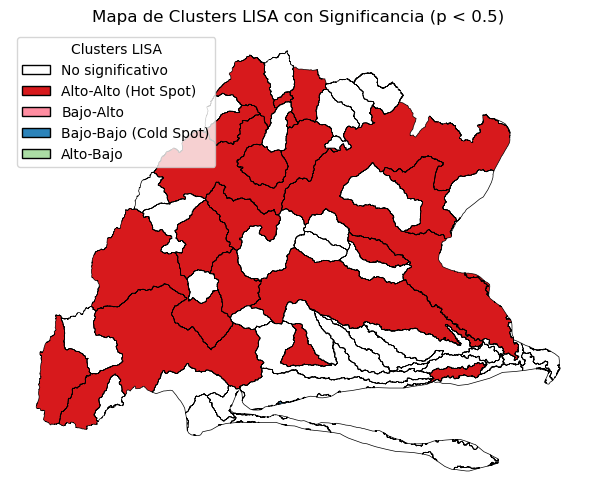

In [50]:
# Crear un diccionario de colores para los clusteres
colors = {
    0: "#ffffff",  # No significativo (blanco)
    1: "#d7191c",  # Alto-Alto (rojo)
    2: "#ff8da1",  # Bajo-Alto (rosa)
    3: "#2b83ba",  # Bajo-Bajo (azul)
    4: "#abdda4",  # Alto-Bajo (verde)
}

# Crear la leyenda con etiquetas descriptivas
legend_labels = {
    0: "No significativo",
    1: "Alto-Alto (Hot Spot)",
    2: "Bajo-Alto",
    3: "Bajo-Bajo (Cold Spot)",
    4: "Alto-Bajo",
}

# Mapeo de colores basado en clusters significativos
AE_UAH_SC1_proj["color"] = AE_UAH_SC1_proj["cluster_signif"].map(colors)

# Graficar
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
AE_UAH_SC1_proj.plot(color=AE_UAH_SC1_proj["color"], edgecolor="black", linewidth=0.5, ax=ax)

# Agregar la leyenda manualmente
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=colors[i], edgecolor="black", label=legend_labels[i]) for i in colors]
ax.legend(handles=legend_patches, title="Clusters LISA", loc="upper left")

# Agregar mapa base si la proyección es métrica
if gdf.crs.to_string().startswith("EPSG:3857"):
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.7)

# Ajustar título y mostrar el mapa
plt.title("Mapa de Clusters LISA con Significancia (p < 0.5)")
plt.axis("off")
plt.show()

** Características de la distribución espacial del NDVI para el año 2025 **
Las coberturas naturales del área de estudio serán clasificados en clases de NDVI con un enfoque orientado a la definición de los grados de sequía que los afecta. Para ello, se analizará la distribución de frecuencias del NDVI en el área cubierta por coberturas naturales y se las categorías definidas por Vergara (2020) con base en la siguiente distribución: 

![Mi_Gráfica](C:/Users/Leydi/Documents/PSIG/NDVI.png)

In [51]:
#Cargar las bandas de Landsat 9
nir_path = "E:/Imag_sequia/img_ae/band_5.tif"  # Ruta de la banda NIR (B5)
red_path = "E:/Imag_sequia/img_ae/band_4.tif"  # Ruta de la banda Roja (B4)

C:\Users\Leydi\AppData\Local\Temp\ipykernel_6504\3628862780.py:9: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


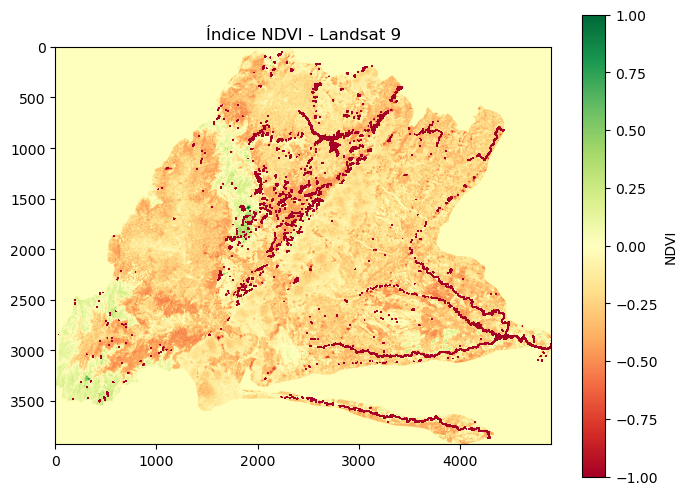

In [68]:
with rasterio.open(nir_path) as nir_src:
    nir = nir_src.read(1).astype('float32')  # Convertir a float para cálculos
    profile = nir_src.profile  # Guardar metadata

with rasterio.open(red_path) as red_src:
    red = red_src.read(1).astype('float32')

# Calcular NDVI evitando división por cero
ndvi = (nir - red) / (nir + red)
ndvi[np.isnan(ndvi)] = -9999  # Asignar valor NoData a NaN

# Guardar el NDVI como GeoTIFF
profile.update(dtype=rasterio.float32, count=1)

with rasterio.open("NDVI_Landsat9.tif", "w", **profile) as dst:
    dst.write(ndvi, 1)

#  Visualizar el NDVI
plt.figure(figsize=(8,6))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title("Índice NDVI - Landsat 9")
plt.savefig("NDVI_AE.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [53]:
import rioxarray as rxr
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

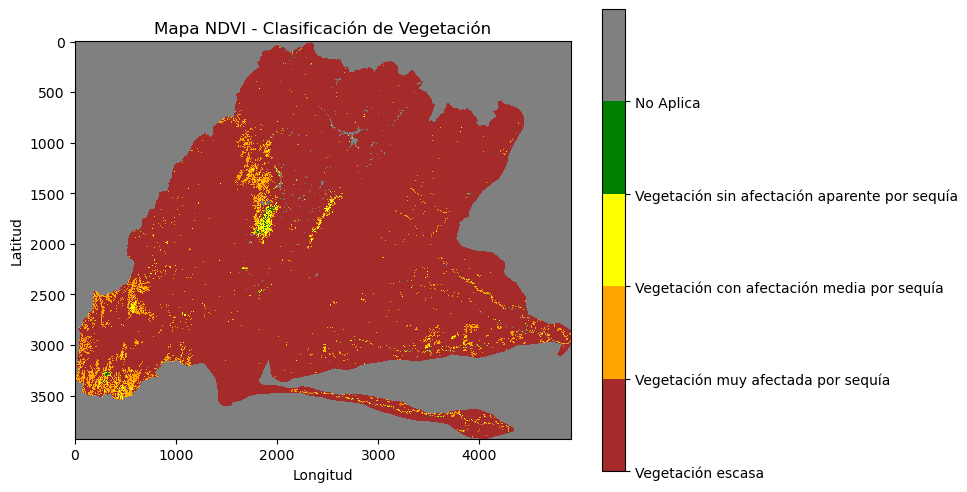

In [69]:

# Cargar el raster de NDVI
ruta_ndvi = "C:/Users/Leydi/Documents/PSIG/data/ProyectoFinalSIG/NDVI_AE.tif"  # Reemplazar con la ruta de tu archivo
ndvi = rxr.open_rasterio(ruta_ndvi, masked=True).squeeze()  # Cargar raster y eliminar dimensión extra

# Definir los rangos y etiquetas del NDVI
bins = [-np.inf, 0.13, 0.26, 0.41, 0.89, np.inf]
labels = [
    "Vegetación escasa", 
    "Vegetación muy afectada por sequía", 
    "Vegetación con afectación media por sequía", 
    "Vegetación sin afectación aparente por sequía"
]

# Crear una matriz de categorías NDVI
ndvi_categorias = np.digitize(ndvi, bins) - 1  # Asigna índices según los bins

# Definir colores para cada categoría
colormap = ListedColormap(["brown", "orange", "yellow", "green", "gray"])
categorias_legenda = [
    "Vegetación escasa", 
    "Vegetación muy afectada por sequía", 
    "Vegetación con afectación media por sequía", 
    "Vegetación sin afectación aparente por sequía",
    "No Aplica"
]

# Graficar el raster con las categorías NDVI
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(ndvi_categorias, cmap=colormap, interpolation='nearest')

# Agregar la leyenda
from matplotlib.colors import BoundaryNorm
cbar = plt.colorbar(im, ticks=range(len(labels)+1), ax=ax)
cbar.set_ticklabels(categorias_legenda)

# Configurar el gráfico
plt.title("Mapa NDVI - Clasificación de Vegetación")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.savefig("Categorias_ndvi.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


In [56]:
# Clasificar cada píxel en su categoría
ndvi_categorias = np.digitize(ndvi, bins) - 1  

# Contar la cantidad de píxeles en cada categoría
conteo_pixeles = {label: np.sum(ndvi_categorias == i) for i, label in enumerate(labels)}

#  Mostrar los resultados
for categoria, conteo in conteo_pixeles.items():
    print(f"{categoria}: {conteo} píxeles")

Vegetación escasa: 10069707 píxeles
Vegetación muy afectada por sequía: 400409 píxeles
Vegetación con afectación media por sequía: 70106 píxeles
Vegetación sin afectación aparente por sequía: 17390 píxeles
